## Sleep Quality Prediction - Supervised Machine Learning

---

by: Cody Hill

date: 1/18/2023

### Data Source Information

### [ ADD LICENSE INFORMATION AND FAIR USE INFO]

In [2069]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

### Setup and Data Cleaning

In [2070]:
# Import data
# TODO: Switch this to the github urls for the data so others can use.
data_folder = '/Users/chill/GitHub/Supervised-Sleep/Data'
sleep_data_folder = '/Users/chill/GitHub/Supervised-Sleep/Data/Sleep_Data'

# Iterate through each file in .Data/ and add it to a dataframe.
file_path = [f'{data_folder}/{file}' for file in os.listdir(data_folder) if '.csv' in file]
# Using a list to concat the dfs with index_col allows to easily merge based on 'day'. More memory usage but fine for this project.
biometric_df = pd.concat([pd.read_csv(file, index_col = 'day') for file in file_path], join = 'outer', ignore_index = False, axis = 1).reset_index()

# Iterate through each file in .Data/Sleep_Data and add it to a dataframe.
# Separated sleep data as it potentially has multiple entries per day. Will merge them later.
file_path_sleep = [f'{sleep_data_folder}/{file}' for file in os.listdir(sleep_data_folder) if '.csv' in file and 'daily' not in file]
sleep_df = pd.concat(map(pd.read_csv, file_path_sleep), join = 'outer', ignore_index = False, axis = 1)

# Import ground truth label sleep score.
file_path_daily_sleep_score = [f'{sleep_data_folder}/{file}' for file in os.listdir(sleep_data_folder) if '.csv' in file and 'daily' in file]
daily_sleep_score_df = pd.read_csv(file_path_daily_sleep_score[0])
daily_sleep_score_df = daily_sleep_score_df[['score', 'day']]

In [2071]:
print(biometric_df.shape)
display(biometric_df.head(2))


(350, 42)


,day,spo2_percentage,active_calories,average_met_minutes,equivalent_walking_distance,high_activity_met_minutes,high_activity_time,inactivity_alerts,low_activity_met_minutes,low_activity_time,...,temperature_deviation,temperature_trend_deviation,contributors_activity_balance,contributors_hrv_balance,contributors_previous_day_activity,contributors_previous_night,contributors_recovery_index,contributors_resting_heart_rate,contributors_sleep_balance,contributors_body_temperature
0,2023-02-04,98.523,650,1.59375,10728,16,120,0,277,23220,...,-0.38,NaN,NaN,NaN,96.0,74.0,97.0,94.0,NaN,90.0
1,2023-02-05,97.181,498,1.43750,8458,8,60,0,204,15000,...,-0.04,0.15,NaN,NaN,82.0,79.0,100.0,59.0,NaN,100.0


In [2072]:
print(sleep_df.shape)
display(sleep_df.head(4))

(685, 47)


,average_breath,average_heart_rate,average_hrv,awake_time,bedtime_end,bedtime_start,day,deep_sleep_duration,efficiency,latency,...,readiness_contributors_body_temperature,readiness_contributors_hrv_balance,readiness_contributors_previous_day_activity,readiness_contributors_previous_night,readiness_contributors_recovery_index,readiness_contributors_resting_heart_rate,readiness_contributors_sleep_balance,readiness_score,readiness_temperature_deviation,readiness_temperature_trend_deviation
0,13.625,63.25,77.0,4440.0,2023-02-04T07:08:22.000-06:00,2023-02-03T22:40:22.000-06:00,2023-02-04,4650.0,85.0,990.0,...,90.0,NaN,96.0,74.0,97.0,94.0,NaN,89.0,-0.38,NaN
1,15.125,92.49,19.0,6210.0,2023-02-05T09:37:28.000-06:00,2023-02-04T23:54:28.000-06:00,2023-02-05,4590.0,82.0,180.0,...,100.0,NaN,82.0,79.0,100.0,59.0,NaN,78.0,-0.04,0.15
2,15.125,87.67,NaN,1920.0,2023-02-05T20:10:57.000-06:00,2023-02-05T19:36:57.000-06:00,2023-02-06,30.0,6.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15.125,82.50,37.0,720.0,2023-02-05T20:36:02.000-06:00,2023-02-05T20:20:02.000-06:00,2023-02-06,0.0,25.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2073]:
biometric_df.columns

Index(['day', 'spo2_percentage', 'active_calories', 'average_met_minutes',
       'equivalent_walking_distance', 'high_activity_met_minutes',
       'high_activity_time', 'inactivity_alerts', 'low_activity_met_minutes',
       'low_activity_time', 'medium_activity_met_minutes',
       'medium_activity_time', 'meters_to_target', 'non_wear_time',
       'resting_time', 'sedentary_met_minutes', 'sedentary_time', 'steps',
       'target_calories', 'target_meters', 'total_calories', 'score',
       'class_5_min', 'contributors_meet_daily_targets',
       'contributors_move_every_hour', 'contributors_recovery_time',
       'contributors_stay_active', 'contributors_training_frequency',
       'contributors_training_volume', 'met_1_min', 'ring_met_1_min', 'score',
       'temperature_deviation', 'temperature_trend_deviation',
       'contributors_activity_balance', 'contributors_hrv_balance',
       'contributors_previous_day_activity', 'contributors_previous_night',
       'contributors_recov

As we can see, the Oura Ring tracks and records many biometrics, and with that raw biometric data they use different equations and feature engineering to assign a daily score to categories such as sleep, recovery, readiness, activity, etc. totalling 86 features. Since the purpose of this is to create our own sleep score predictive model, we can use Oura's sleep score as our ground truth label (y_train) in training and validation. Furthermore, we must remove the features with labels that include "contributors" as these columns contain normalized scores which Oura's models have output that are then used to average out into the final score.

In [2074]:
# Remove contributor and score columns (multiple scores involved, will add truth label later).
biometric_df = biometric_df.loc[:, ~biometric_df.columns.str.contains('contributors|score')]
print(biometric_df.shape)

sleep_df = sleep_df.loc[:, ~sleep_df.columns.str.contains('contributors|score')]
print(sleep_df.shape)

(350, 26)
(685, 30)


We've removed 31 feature columns containing the word contributors.

Now we will remove all columns that won't be used in feature engineering or the final model.
Then complete data munging by formatting all the features (float, int, dates, dummy/indicator encoding).

In [2075]:
biometric_df.columns

Index(['day', 'spo2_percentage', 'active_calories', 'average_met_minutes',
       'equivalent_walking_distance', 'high_activity_met_minutes',
       'high_activity_time', 'inactivity_alerts', 'low_activity_met_minutes',
       'low_activity_time', 'medium_activity_met_minutes',
       'medium_activity_time', 'meters_to_target', 'non_wear_time',
       'resting_time', 'sedentary_met_minutes', 'sedentary_time', 'steps',
       'target_calories', 'target_meters', 'total_calories', 'class_5_min',
       'met_1_min', 'ring_met_1_min', 'temperature_deviation',
       'temperature_trend_deviation'],
      dtype='object')

In [2076]:
# # TODO: oura_sleep_2024-01.csv
# X - Nap on day encoding
#  X - list(where [type] != long_sleep && between 10 AM - 7 PM)
#       Does the nap affect day of or next day? I chose day of
#  X - sum(types of sleep duration)
# - restless_periods vs sum(movement_30_sec)??
# X - Only one day per entry
#   X - Sum each day sleep durations, restless_periods, awake_time, time_in_bed, total_sleep_duration
#       - awake_time = time_in_bed - total_sleep_duration ??
#   X - Save only the [type] == long_sleep, average_breath, average_heart_rate, average_hrv, latency, 
#       lowest_heart_rate, betime_start_delta
# X - Remove: efficiency, period, score, segment_state, sleep_midpoint, sleep_phase_5_min, movement_30_sec, timezone, 
#       betime_end_delta, midpoint_at_delta, heart_rate_5_min, hrv_5_min

# # TODO: oura_daily-activity_2024-01.csv
# X - Remove: average_met_minutes, equivalent_walking_distance, high_activity_met_minutes, inactivity_alerts, 
#       low_activity_met_minutes, medium_activity_met_minutes, sedentary_met_minutes, target_calories, target_meters, score,
#       class_5_min, met_1_min, ring_met_1_min
# - Workout daily boolean (Maybe unnecessary with other metrics compare models w/ and w/o)
# - Assign all activity to previous day???

# # TODO: oura_daily-readiness_2024-01.csv
# X - Remove: score, temperature_trend_deviation

# # TODO: oura_daily--spo2_2024-01.csv
# - N/A
# -
# -

# # TODO: General
# - Collinearity between features checks in model selection
# - Any features need to be normalized?
# - Create Readme
# - Create systeminfo output
# - Reroute filepath to github url
# - Deal with NaNs!
# - Bin the Ys!
# - Balance train and test split classes?
# - Regression instead? (y back to discrete)
# - ROC Curve or F1
# - Previous Day's Sleep Score feature
# - oversampling/SMOTE 
# - Different models
# - Reduce Features (Could use sklearn from sklearn.feature_selection import RFE)

In [2077]:
biometric_df.loc[biometric_df['day'] == '2024-01-14']

,day,spo2_percentage,active_calories,average_met_minutes,equivalent_walking_distance,high_activity_met_minutes,high_activity_time,inactivity_alerts,low_activity_met_minutes,low_activity_time,...,sedentary_time,steps,target_calories,target_meters,total_calories,class_5_min,met_1_min,ring_met_1_min,temperature_deviation,temperature_trend_deviation
324,2024-01-14,NaN,439,1.375,7630,0,0,0,212,15000,...,20100,7651,500,10000,2713,1111111111111111111111111111111111111111111111...,1.2;1.2;1.0;1.0;0.9;0.9;1.1;0.9;0.9;1.0;0.9;0....,1.2;1.2;1.0;1.0;0.9;0.9;1.1;0.9;0.9;1.0;0.9;0....,-0.12,0.1


In [2078]:
biometric_df['day'].duplicated().sum()

0

In [2079]:
# Columns to drop
drop_col_sleep = ['efficiency', 'period', 'segment_state',
            'sleep_midpoint', 'sleep_phase_5_min', 'movement_30_sec',
            'timezone', 'bedtime_end_delta', 'midpoint_at_delta',
            'heart_rate_5_min', 'hrv_5_min'] # timezone? might use later
drop_col_bio = ['average_met_minutes', 'equivalent_walking_distance', 
                'high_activity_met_minutes', 'inactivity_alerts', 
                'low_activity_met_minutes', 'medium_activity_met_minutes', 
                'sedentary_met_minutes', 'target_calories', 
                'target_meters', 'class_5_min', 
                'met_1_min', 'ring_met_1_min', 
                'temperature_trend_deviation']
# Columns to format to dates in sleep_df
date_col = ['bedtime_end', 'bedtime_start', 'day']

sleep_df.drop(drop_col_sleep, axis = 1, inplace = True)
sleep_df[date_col] = sleep_df[date_col].apply(pd.to_datetime, utc = True, errors = 'coerce')
biometric_df.drop(drop_col_bio, axis = 1, inplace = True)
biometric_df['day'] = biometric_df['day'].apply(pd.to_datetime, utc = True, errors = 'coerce')
daily_sleep_score_df['day'] = daily_sleep_score_df['day'].apply(pd.to_datetime, utc = True, errors = 'coerce')

In [2080]:
tzone = -240
f"{int(tzone / 10 / 6)}:00"

'-4:00'

In [2081]:
print(sleep_df.shape)
display(sleep_df.head(4))
sleep_df.dtypes

(685, 19)


,average_breath,average_heart_rate,average_hrv,awake_time,bedtime_end,bedtime_start,day,deep_sleep_duration,latency,light_sleep_duration,lowest_heart_rate,rem_sleep_duration,restless_periods,time_in_bed,total_sleep_duration,type,bedtime_start_delta,readiness_temperature_deviation,readiness_temperature_trend_deviation
0,13.625,63.25,77.0,4440.0,2023-02-04 13:08:22+00:00,2023-02-04 04:40:22+00:00,2023-02-04 00:00:00+00:00,4650.0,990.0,15570.0,56.0,5820.0,282.0,30480,26040.0,long_sleep,-4778,-0.38,NaN
1,15.125,92.49,19.0,6210.0,2023-02-05 15:37:28+00:00,2023-02-05 05:54:28+00:00,2023-02-05 00:00:00+00:00,4590.0,180.0,14970.0,75.0,9210.0,240.0,34980,28770.0,long_sleep,-332,-0.04,0.15
2,15.125,87.67,NaN,1920.0,2023-02-06 02:10:57+00:00,2023-02-06 01:36:57+00:00,2023-02-06 00:00:00+00:00,30.0,0.0,90.0,86.0,0.0,0.0,2040,120.0,NaN,-15783,NaN,NaN
3,15.125,82.50,37.0,720.0,2023-02-06 02:36:02+00:00,2023-02-06 02:20:02+00:00,2023-02-06 00:00:00+00:00,0.0,0.0,240.0,82.0,0.0,8.0,960,240.0,NaN,-13198,NaN,NaN


average_breath                                       float64
average_heart_rate                                   float64
average_hrv                                          float64
awake_time                                           float64
bedtime_end                              datetime64[ns, UTC]
bedtime_start                            datetime64[ns, UTC]
day                                      datetime64[ns, UTC]
deep_sleep_duration                                  float64
latency                                              float64
light_sleep_duration                                 float64
lowest_heart_rate                                    float64
rem_sleep_duration                                   float64
restless_periods                                     float64
time_in_bed                                            int64
total_sleep_duration                                 float64
type                                                  object
bedtime_start_delta     

In [2082]:
# Initialize a time frame we can consider a nap/rest period (UTC format).
nap_upper = pd.to_datetime('23:59:00').time()
nap_lower = pd.to_datetime('14:00:00').time()
# Condition on the start and end time, total sleep duration to filter out false-positives, remove any long_sleep types.
nap_bool = ((sleep_df['bedtime_start'].dt.time >= nap_lower) & 
            (sleep_df['bedtime_end'].dt.time <= nap_upper) & 
            (sleep_df['total_sleep_duration'] > 600) &
            (sleep_df['type'] != 'long_sleep'))
display(sleep_df[nap_bool])
# Insert a nap_today column and binary yes/no for each day.
# Initialize column with zeroes.
sleep_df['nap_today'] = np.zeros_like(sleep_df.shape[0])
# Use boolean array to identify nap days and iterate through to change nap_today to 1.
nap_days = sleep_df[nap_bool]['day']
for day in nap_days:
    sleep_df.loc[sleep_df['day'] == day, 'nap_today'] = 1
    
display(sleep_df.loc[sleep_df['nap_today'] == 1])

,average_breath,average_heart_rate,average_hrv,awake_time,bedtime_end,bedtime_start,day,deep_sleep_duration,latency,light_sleep_duration,lowest_heart_rate,rem_sleep_duration,restless_periods,time_in_bed,total_sleep_duration,type,bedtime_start_delta,readiness_temperature_deviation,readiness_temperature_trend_deviation
31,13.500,74.47,34.0,6270.0,2023-02-20 21:16:13+00:00,2023-02-20 19:05:13+00:00,2023-02-20 00:00:00+00:00,420.0,570.0,840.0,67.0,330.0,25.0,7860,1590.0,NaN,47113,NaN,NaN
34,13.875,70.14,58.0,3540.0,2023-02-21 23:27:03+00:00,2023-02-21 21:59:03+00:00,2023-02-21 00:00:00+00:00,120.0,3600.0,1140.0,60.0,480.0,23.0,5280,1740.0,NaN,57543,NaN,NaN
44,14.750,90.50,25.0,3690.0,2023-02-27 01:11:23+00:00,2023-02-26 23:54:23+00:00,2023-02-27 00:00:00+00:00,300.0,2760.0,540.0,90.0,90.0,24.0,4620,930.0,NaN,60863,NaN,NaN
53,14.750,NaN,NaN,1140.0,2023-03-01 23:27:00+00:00,2023-03-01 22:51:00+00:00,2023-03-01 00:00:00+00:00,570.0,750.0,420.0,NaN,30.0,11.0,2160,1020.0,NaN,60660,NaN,NaN
63,14.625,71.67,NaN,930.0,2023-03-06 22:03:32+00:00,2023-03-06 21:30:32+00:00,2023-03-06 00:00:00+00:00,630.0,390.0,420.0,70.0,0.0,31.0,1980,1050.0,NaN,55832,NaN,NaN
88,13.750,65.15,75.0,1530.0,2023-03-17 21:33:33+00:00,2023-03-17 20:17:33+00:00,2023-03-17 00:00:00+00:00,90.0,450.0,2940.0,62.0,0.0,88.0,4560,3030.0,NaN,55053,NaN,NaN
89,13.750,68.33,63.0,2070.0,2023-03-17 23:52:33+00:00,2023-03-17 22:48:33+00:00,2023-03-18 00:00:00+00:00,540.0,1410.0,780.0,63.0,450.0,12.0,3840,1770.0,late_nap,64113,NaN,NaN
116,13.625,70.40,70.0,3030.0,2023-03-30 20:27:01+00:00,2023-03-30 19:26:01+00:00,2023-03-30 00:00:00+00:00,180.0,690.0,450.0,68.0,0.0,10.0,3660,630.0,NaN,51961,NaN,NaN
152,14.125,61.20,107.0,750.0,2023-04-23 21:10:49+00:00,2023-04-23 20:29:49+00:00,2023-04-23 00:00:00+00:00,1260.0,330.0,450.0,56.0,0.0,15.0,2460,1710.0,sleep,55789,NaN,NaN
180,14.875,71.20,80.0,1080.0,2023-05-10 18:45:42+00:00,2023-05-10 17:44:42+00:00,2023-05-10 00:00:00+00:00,810.0,570.0,1770.0,67.0,0.0,29.0,3660,2580.0,sleep,45882,NaN,NaN


,average_breath,average_heart_rate,average_hrv,awake_time,bedtime_end,bedtime_start,day,deep_sleep_duration,latency,light_sleep_duration,lowest_heart_rate,rem_sleep_duration,restless_periods,time_in_bed,total_sleep_duration,type,bedtime_start_delta,readiness_temperature_deviation,readiness_temperature_trend_deviation,nap_today
30,13.500,65.80,78.0,7350.0,2023-02-20 12:52:29+00:00,2023-02-20 04:44:29+00:00,2023-02-20 00:00:00+00:00,5010.0,1590.0,13770.0,55.0,3150.0,254.0,29280,21930.0,long_sleep,-4531,-0.10,0.15,1
31,13.500,74.47,34.0,6270.0,2023-02-20 21:16:13+00:00,2023-02-20 19:05:13+00:00,2023-02-20 00:00:00+00:00,420.0,570.0,840.0,67.0,330.0,25.0,7860,1590.0,NaN,47113,NaN,NaN,1
32,13.500,77.00,33.0,1410.0,2023-02-21 03:25:01+00:00,2023-02-21 02:54:01+00:00,2023-02-21 00:00:00+00:00,60.0,570.0,210.0,76.0,180.0,9.0,1860,450.0,NaN,-11159,NaN,NaN,1
33,13.875,61.19,109.0,3360.0,2023-02-21 13:55:00+00:00,2023-02-21 05:51:00+00:00,2023-02-21 00:00:00+00:00,7620.0,180.0,12510.0,50.0,5550.0,302.0,29040,25680.0,long_sleep,-540,-0.17,0.02,1
34,13.875,70.14,58.0,3540.0,2023-02-21 23:27:03+00:00,2023-02-21 21:59:03+00:00,2023-02-21 00:00:00+00:00,120.0,3600.0,1140.0,60.0,480.0,23.0,5280,1740.0,NaN,57543,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,14.875,83.27,15.0,4163.0,2023-12-16 13:31:27+00:00,2023-12-16 05:01:04+00:00,2023-12-16 00:00:00+00:00,4290.0,1230.0,13860.0,79.0,8310.0,218.0,30623,26460.0,long_sleep,-3536,0.17,0.16,1
617,14.750,74.90,45.0,1830.0,2023-12-16 22:11:30+00:00,2023-12-16 21:04:30+00:00,2023-12-16 00:00:00+00:00,150.0,1260.0,2040.0,66.0,0.0,38.0,4020,2190.0,NaN,54270,NaN,0.10,1
652,14.250,NaN,NaN,1261.0,2024-01-02 05:10:34+00:00,2024-01-02 04:43:03+00:00,2024-01-02 00:00:00+00:00,0.0,1110.0,390.0,NaN,0.0,8.0,1651,390.0,NaN,-4617,NaN,0.27,1
653,14.375,75.64,62.0,2958.0,2024-01-02 14:20:52+00:00,2024-01-02 06:33:04+00:00,2024-01-02 00:00:00+00:00,4620.0,450.0,15360.0,60.0,5130.0,169.0,28068,25110.0,long_sleep,1984,0.03,0.22,1


In [2083]:
biometric_df['day'] = biometric_df['day'] + pd.DateOffset(days = 1)
display(biometric_df)
sleep_min_idx = sleep_df.loc[sleep_df['day'] == sleep_df['day'].min()].index
bio_min_idx = biometric_df.loc[biometric_df['day'] == biometric_df['day'].min()].index
bio_max_idx = biometric_df.loc[biometric_df['day'] == biometric_df['day'].max()].index

#biometric_df.drop(index = bio_min_idx, axis = 0, inplace = True)
biometric_df.drop(index = bio_max_idx, axis = 0, inplace = True)
# sleep_df.drop(sleep_min_idx, axis = 0, inplace = True)

# biometric_df.reset_index(drop = True, inplace = True)
# sleep_df.reset_index(drop = True, inplace = True)

print(biometric_df['day'].min())
print(sleep_df['day'].min())
print(biometric_df['day'].max())
print(sleep_df['day'].max())

biometric_df.loc[biometric_df['day'] == '2023-02-04 00:00:00+00:00']

,day,spo2_percentage,active_calories,high_activity_time,low_activity_time,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_time,steps,total_calories,temperature_deviation
0,2023-02-05 00:00:00+00:00,98.523,650,120,23220,2940,0,0,25740,34380,11638,3075,-0.38
1,2023-02-06 00:00:00+00:00,97.181,498,60,15000,2580,2700,0,35280,33480,9001,2814,-0.04
2,2023-02-07 00:00:00+00:00,99.177,400,120,13440,2160,5300,0,31080,39600,7544,2748,-0.22
3,2023-02-08 00:00:00+00:00,98.634,523,0,16560,3180,2300,4800,31020,30840,8668,2852,-0.25
4,2023-02-10 00:00:00+00:00,98.440,530,60,13440,3780,-400,1200,35040,32880,8728,2876,-0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,2023-09-22 00:00:00+00:00,NaN,899,180,26760,5400,-6800,3000,30000,21060,18552,3292,NaN
346,2023-10-17 00:00:00+00:00,NaN,472,60,13680,2760,500,0,33960,35940,8701,2761,-0.20
347,2023-11-06 00:00:00+00:00,NaN,563,120,16920,2580,-1000,19200,21660,25920,9925,2906,NaN
348,2023-11-30 00:00:00+00:00,NaN,97,0,3180,480,7100,0,49260,33480,1601,2229,NaN


2023-02-04 00:00:00+00:00
2023-02-04 00:00:00+00:00
2024-01-18 00:00:00+00:00
2024-01-18 00:00:00+00:00


,day,spo2_percentage,active_calories,high_activity_time,low_activity_time,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_time,steps,total_calories,temperature_deviation
329,2023-02-04 00:00:00+00:00,NaN,140,0,8460,120,6300,36000,19680,22140,2718,2429,NaN


In [2084]:
sleep_df_long = sleep_df.loc[sleep_df['type'] == 'long_sleep']

# Use merge() to find the differences in dataframes indicating days that didn't record a long sleep.
# Requires a method where the two df indexes don't match.
# Method credit to: https://stackoverflow.com/questions/48647534/find-difference-between-two-data-frames
no_sleep = pd.DataFrame(sleep_df['day']).merge(sleep_df_long['day'], indicator = True, how='left').loc[lambda x : x['_merge']!='both']
display(no_sleep)

# We can remove these days from the main dataframes as they won't have scores anyways.
# Sleep DF
sleep_df.drop(no_sleep.index, axis = 0, inplace = True)

# Biometric DF
# We can use our previous work and just remove the days that the two DFs don't share.
no_sleep_bio_days =  pd.DataFrame(biometric_df['day']).merge(sleep_df['day'], indicator = True, how='left').loc[lambda x : x['_merge']!='both']['day']
no_sleep_bio_index = biometric_df[biometric_df['day'].isin(no_sleep_bio_days)].index

biometric_df.drop(no_sleep_bio_index, axis = 0, inplace = True)

# Daily Sleep Score DF
no_sleep_score_index = pd.DataFrame(daily_sleep_score_df['day']).merge(biometric_df['day'], indicator = True, how='left').loc[lambda x : x['_merge']!='both']['day'].index
daily_sleep_score_df.drop(index = no_sleep_score_index, axis = 0, inplace = True)
# Instead of having 0-100 potential label predictions we should bin them.
# Create bins. We can use .5 to avoid having to decide left or right edge issues.
bins = np.linspace(0.5, 100.5, 21, dtype = float)
bin_labels = [f"{i} to {i + 5}" for i in bins if i != bins[-1]]
# np.digitize() can map the scores to the correct bins
bin_idx = np.digitize(daily_sleep_score_df['score'], bins, right = False)
# Create new column with the new bin labels
daily_sleep_score_df['score_bin'] = [bin_labels[value - 1] for value in bin_idx]
display(daily_sleep_score_df.head(5))
# We can now remove the day column from the daily_sleep_score_df
#daily_sleep_score_df.drop(daily_sleep_score_df.loc[daily_sleep_score_df['day'] == daily_sleep_score_df['day'].min()].index, axis = 0, inplace = True)
print(daily_sleep_score_df['day'].min())
print(daily_sleep_score_df['day'].max())
daily_sleep_score_df.drop(['day'], axis = 1, inplace = True)

,day,_merge
103,2023-03-24 00:00:00+00:00,left_only
140,2023-04-15 00:00:00+00:00,left_only
161,2023-05-01 00:00:00+00:00,left_only
162,2023-05-01 00:00:00+00:00,left_only
163,2023-05-02 00:00:00+00:00,left_only
173,2023-05-08 00:00:00+00:00,left_only
223,2023-05-28 00:00:00+00:00,left_only
224,2023-05-28 00:00:00+00:00,left_only
326,2023-07-24 00:00:00+00:00,left_only
402,2023-08-31 00:00:00+00:00,left_only


,score,day,score_bin
0,81,2023-02-04 00:00:00+00:00,80.5 to 85.5
1,81,2023-02-05 00:00:00+00:00,80.5 to 85.5
2,89,2023-02-06 00:00:00+00:00,85.5 to 90.5
3,78,2023-02-07 00:00:00+00:00,75.5 to 80.5
4,80,2023-02-08 00:00:00+00:00,75.5 to 80.5


2023-02-04 00:00:00+00:00
2024-01-18 00:00:00+00:00


In [2085]:
# Sum each day's sleep metrics (for days with interrupted sleep or naps).
sleep_df = sleep_df[['day', 
         'deep_sleep_duration', 
         'light_sleep_duration', 
         'rem_sleep_duration', 
         'restless_periods', 
         'awake_time', 
         'time_in_bed', 
         'total_sleep_duration']].groupby(['day']).sum().reset_index()

In [2086]:
# Features extracted only from the long sleep to include in the final dateframe.
sleep_df_long = sleep_df_long[['day', 
                               'average_breath', 
                               'average_heart_rate', 
                               'average_hrv', 
                               'latency', 
                               'lowest_heart_rate', 
                               'bedtime_start_delta',
                               'nap_today']]

In [2087]:
sleep_df = sleep_df.merge(sleep_df_long, on = 'day', how = 'outer')
sleep_df.head(2)

/Users/chill/Library/Python/3.11/lib/python/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,day,deep_sleep_duration,light_sleep_duration,rem_sleep_duration,restless_periods,awake_time,time_in_bed,total_sleep_duration,average_breath,average_heart_rate,average_hrv,latency,lowest_heart_rate,bedtime_start_delta,nap_today
0,2023-02-04 00:00:00+00:00,4650.0,15570.0,5820.0,282.0,4440.0,30480,26040.0,13.625,63.25,77.0,990.0,56.0,-4778,0
1,2023-02-05 00:00:00+00:00,4590.0,14970.0,9210.0,240.0,6210.0,34980,28770.0,15.125,92.49,19.0,180.0,75.0,-332,0


In [2088]:
sleep_df.shape

(334, 15)

In [2089]:
biometric_df.shape

(334, 13)

In [2090]:
daily_sleep_score_df.shape

(334, 2)

In [2091]:
bio_sleep_df = sleep_df.merge(biometric_df, on = 'day', how = 'outer')
bio_sleep_df.drop(['day'], axis = 1, inplace = True)
display(bio_sleep_df)
bio_sleep_df.iloc[287]

,deep_sleep_duration,light_sleep_duration,rem_sleep_duration,restless_periods,awake_time,time_in_bed,total_sleep_duration,average_breath,average_heart_rate,average_hrv,...,high_activity_time,low_activity_time,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_time,steps,total_calories,temperature_deviation
0,4650.0,15570.0,5820.0,282.0,4440.0,30480,26040.0,13.625,63.25,77.0,...,0,8460,120,6300,36000,19680,22140,2718,2429,NaN
1,4590.0,14970.0,9210.0,240.0,6210.0,34980,28770.0,15.125,92.49,19.0,...,120,23220,2940,0,0,25740,34380,11638,3075,-0.38
2,8580.0,15210.0,7350.0,302.0,6240.0,37380,31140.0,13.625,68.76,59.0,...,60,15000,2580,2700,0,35280,33480,9001,2814,-0.04
3,4500.0,17700.0,6030.0,284.0,5010.0,33240,28230.0,13.500,67.25,54.0,...,120,13440,2160,5300,0,31080,39600,7544,2748,-0.22
4,4920.0,15630.0,6420.0,245.0,6210.0,33180,26970.0,13.875,69.50,49.0,...,0,16560,3180,2300,4800,31020,30840,8668,2852,-0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,3090.0,19680.0,5760.0,253.0,9469.0,37999,28530.0,13.625,66.03,67.0,...,300,18900,5580,-6500,180,35760,25680,14452,3212,0.15
330,5610.0,17970.0,5340.0,288.0,6456.0,35376,28920.0,13.875,69.69,67.0,...,0,15000,1860,1100,14580,34860,20100,7651,2713,-0.12
331,5910.0,11310.0,4230.0,240.0,4734.0,26184,21450.0,13.500,57.40,106.0,...,240,18840,3300,-300,540,27960,35520,11561,3064,0.05
332,5640.0,10230.0,7020.0,221.0,3768.0,26658,22890.0,13.875,57.75,140.0,...,0,19920,1740,900,300,26880,37560,8525,2879,-0.33


deep_sleep_duration       4080.000
light_sleep_duration     16110.000
rem_sleep_duration        3390.000
restless_periods           223.000
awake_time               27456.000
time_in_bed              51036.000
total_sleep_duration     23580.000
average_breath              14.250
average_heart_rate          81.180
average_hrv                 33.000
latency                   1380.000
lowest_heart_rate           67.000
bedtime_start_delta       2671.000
nap_today                    1.000
spo2_percentage             98.626
active_calories            532.000
high_activity_time          60.000
low_activity_time        16560.000
medium_activity_time      2760.000
meters_to_target         -3000.000
non_wear_time              180.000
resting_time             21180.000
sedentary_time           45660.000
steps                     9435.000
total_calories            2957.000
temperature_deviation        0.120
Name: 287, dtype: float64

In [2092]:
bio_sleep_df.columns

Index(['deep_sleep_duration', 'light_sleep_duration', 'rem_sleep_duration',
       'restless_periods', 'awake_time', 'time_in_bed', 'total_sleep_duration',
       'average_breath', 'average_heart_rate', 'average_hrv', 'latency',
       'lowest_heart_rate', 'bedtime_start_delta', 'nap_today',
       'spo2_percentage', 'active_calories', 'high_activity_time',
       'low_activity_time', 'medium_activity_time', 'meters_to_target',
       'non_wear_time', 'resting_time', 'sedentary_time', 'steps',
       'total_calories', 'temperature_deviation'],
      dtype='object')

In [2093]:
# Explore and deal with NaN values.
# A good option to deal with each feature individually.
# >>> values = {{"A": 0, "B": 1, "C": 2, "D": 3}}
# >>> df.fillna(value=values)
# Only feature with NaN currently is SPO2, median for now.
# TODO: Come back and tune each feature.
display(bio_sleep_df.isna().any())
bio_sleep_df.fillna(bio_sleep_df.median(), inplace = True)

deep_sleep_duration      False
light_sleep_duration     False
rem_sleep_duration       False
restless_periods         False
awake_time               False
time_in_bed              False
total_sleep_duration     False
average_breath           False
average_heart_rate       False
average_hrv              False
latency                  False
lowest_heart_rate        False
bedtime_start_delta      False
nap_today                False
spo2_percentage           True
active_calories          False
high_activity_time       False
low_activity_time        False
medium_activity_time     False
meters_to_target         False
non_wear_time            False
resting_time             False
sedentary_time           False
steps                    False
total_calories           False
temperature_deviation     True
dtype: bool

### Exploratory Data Analysis (EDA)

In [2094]:
daily_sleep_score_df.describe()

,score
count,334.000000
mean,75.688623
std,8.384459
min,36.000000
25%,71.000000
50%,77.000000
75%,81.000000
max,94.000000


<Axes: >

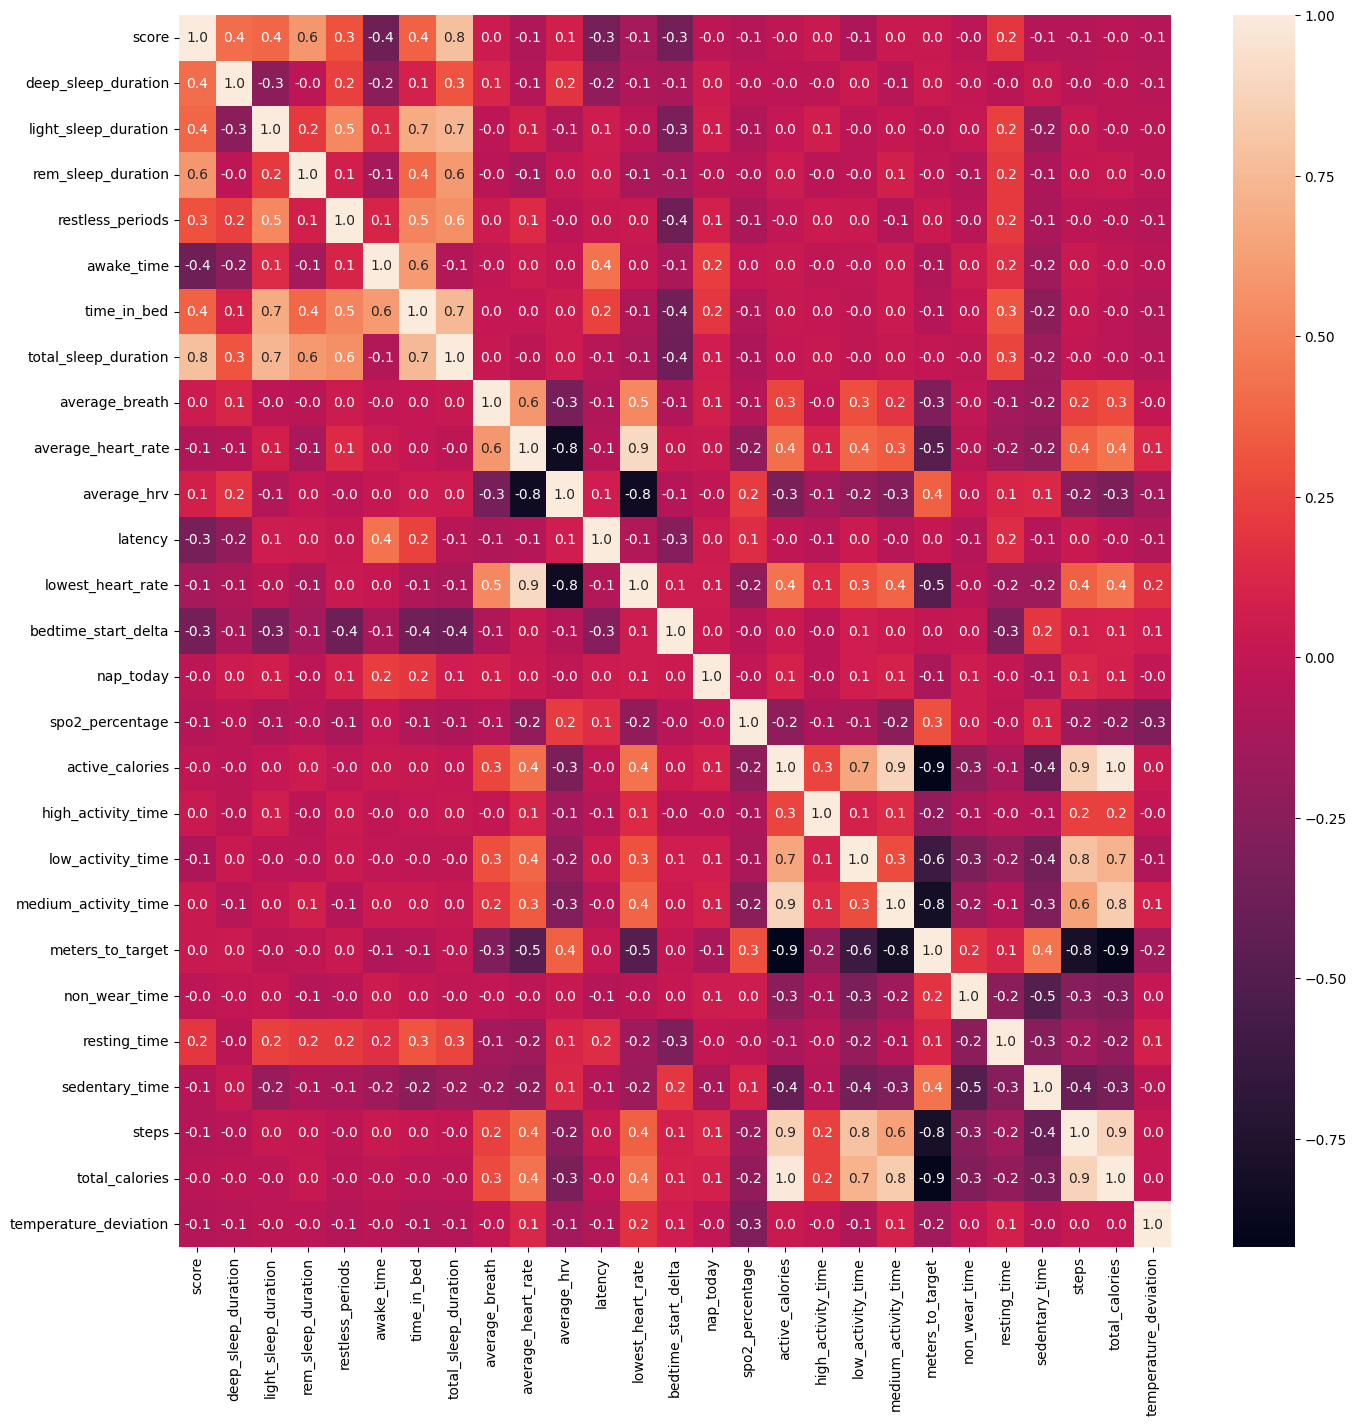

In [2145]:
# Correlation
corr_matrix = pd.concat([daily_sleep_score_df['score'], bio_sleep_df], axis = 1).corr()
fig, ax = plt.subplots(figsize = (16, 16))
# Include score column to see correlation between response and predictors too.
sns.heatmap(corr_matrix, ax = ax, annot = True,  fmt = '.1f')

In [2148]:
corr_matrix_abs = corr_matrix.abs()

corr_matrix_abs.drop('score', axis = 0, inplace = True)
corr_matrix_abs.drop('score', axis = 1, inplace = True)

upper_tri = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k = 1).astype(bool))
# threshold greater than 0.75
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.75)]
print(to_drop)

['average_hrv', 'lowest_heart_rate', 'medium_activity_time', 'meters_to_target', 'steps', 'total_calories']


#### Standardize Features
Since we'll be using many machine learning models in which regularization techniques are sensitive to differences in predictor variance magnitudes/scale (e.g., Lasso/Ridge Regression, SVM, etc.) and expect features to be roughly normally distributed, we will be standardizing the features appropriately.

### Helper Functions

In [2096]:
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid['max_depth']), len(grid.param_grid['max_leaf_nodes']))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('max_leaf_nodes')
    plt.ylabel('max_depth')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid['max_leaf_nodes'])), grid.param_grid['max_leaf_nodes'], rotation=90)
    plt.yticks(np.arange(len(grid.param_grid['max_depth'])), grid.param_grid['max_depth'])
    plt.title('Validation accuracy')
    plt.show()

def plotSearchGridSVM(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid['C']), len(grid.param_grid['gamma']))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('Gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid['gamma'])), grid.param_grid['gamma'], rotation=90)
    plt.yticks(np.arange(len(grid.param_grid['C'])), grid.param_grid['C'])
    plt.title('Validation accuracy')
    plt.show()

### Model Selection

#### Train Test Split

---



In [2097]:
display(daily_sleep_score_df['score_bin'].value_counts())
# Remove outlier for now so we can class-balance the splits (min per class required = 2)
# TODO: Remove hardcoded solution, get counts and delete if == 1 in case of new data.
#       (Maybe use daily_sleep_score_df['score_bin'].value_counts() == 1)
class_outlier_loc = daily_sleep_score_df.loc[daily_sleep_score_df['score_bin'] == '35.5 to 40.5']
print(class_outlier_loc)
daily_sleep_score_df.drop(class_outlier_loc.index, axis = 0, inplace = True)
bio_sleep_df.drop(class_outlier_loc.index, axis = 0, inplace = True)

score_bin
75.5 to 80.5    86
80.5 to 85.5    72
70.5 to 75.5    69
65.5 to 70.5    41
85.5 to 90.5    26
60.5 to 65.5    24
55.5 to 60.5     7
90.5 to 95.5     3
45.5 to 50.5     3
40.5 to 45.5     2
35.5 to 40.5     1
Name: count, dtype: int64

     score     score_bin
287     36  35.5 to 40.5


In [2098]:
rand_state = 98784 # Used in all classifiers
# Binned/Categorical Class Labels
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(bio_sleep_df, daily_sleep_score_df['score_bin'], 
                                                    test_size = 0.2, 
                                                    random_state = rand_state, 
                                                    stratify = daily_sleep_score_df['score_bin'])
# Discretized Scores
# Can't stratify-balance the classes with this low amount of data
X_train, X_test, y_train, y_test = train_test_split(bio_sleep_df, daily_sleep_score_df['score'], 
                                                    test_size = 0.2, 
                                                    random_state = rand_state)

#### Linear Regression / Logistic Classification

In [2099]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
# import scipy as sp
# import scipy.stats as stats
import statsmodels.formula.api as smf

clf_log_regression = LogisticRegression(solver = 'sag', max_iter = 10000, random_state = rand_state).fit(X_train_bin, y_train_bin)
print(clf_log_regression.score(X_test_bin, y_test_bin))

clf_lin_regression = LinearRegression(random_state = rand_state).fit(X_train, y_train)
print(clf_lin_regression.score(X_test, y_test))
feat_coef = list(zip(clf_lin_regression.coef_, clf_lin_regression.feature_names_in_))
print(feat_coef)

clf_ridge_regression = Ridge(max_iter = 10000, random_state = rand_state).fit(X_train, y_train)
print(clf_ridge_regression.score(X_test, y_test))

clf_lasso_regression = Lasso(max_iter = 10000, random_state = rand_state).fit(X_train, y_train)
print(clf_lasso_regression.score(X_test, y_test))

0.08955223880597014
0.8358979478099986
[(3092105850.865379, 'deep_sleep_duration'), (3092105850.864738, 'light_sleep_duration'), (3092105850.865996, 'rem_sleep_duration'), (-0.016845635010860293, 'restless_periods'), (-0.00535271536724125, 'awake_time'), (0.004885230698459794, 'time_in_bed'), (-3092105850.868396, 'total_sleep_duration'), (0.27251901284489094, 'average_breath'), (0.035574131902328554, 'average_heart_rate'), (-0.009938004701544526, 'average_hrv'), (-0.002140572192667384, 'latency'), (-0.08067770780748922, 'lowest_heart_rate'), (-0.0005881981794157718, 'bedtime_start_delta'), (0.8326901324452636, 'nap_today'), (0.06944152563917572, 'spo2_percentage'), (0.006576239725795764, 'active_calories'), (-0.00011757303484651174, 'high_activity_time'), (-0.00019600005816294456, 'low_activity_time'), (-0.00032814509683248095, 'medium_activity_time'), (7.389086260459027e-05, 'meters_to_target'), (7.325977995961018e-06, 'non_wear_time'), (9.729937355196385e-05, 'resting_time'), (3.2407

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.449e+02, tolerance: 1.610e+00
  model = cd_fast.enet_coordinate_descent(


In [2170]:
bio_sleep_df.reset_index(drop = True, inplace = True)
daily_sleep_score_df.reset_index(drop = True, inplace = True)

ols_format_df = pd.concat([daily_sleep_score_df['score'], bio_sleep_df], axis = 1)

In [2171]:
ols_format_df

,score,deep_sleep_duration,light_sleep_duration,rem_sleep_duration,restless_periods,awake_time,time_in_bed,total_sleep_duration,average_breath,average_heart_rate,...,high_activity_time,low_activity_time,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_time,steps,total_calories,temperature_deviation
0,81,4650.0,15570.0,5820.0,282.0,4440.0,30480,26040.0,13.625,63.25,...,0,8460,120,6300,36000,19680,22140,2718,2429,0.02
1,81,4590.0,14970.0,9210.0,240.0,6210.0,34980,28770.0,15.125,92.49,...,120,23220,2940,0,0,25740,34380,11638,3075,-0.38
2,89,8580.0,15210.0,7350.0,302.0,6240.0,37380,31140.0,13.625,68.76,...,60,15000,2580,2700,0,35280,33480,9001,2814,-0.04
3,78,4500.0,17700.0,6030.0,284.0,5010.0,33240,28230.0,13.500,67.25,...,120,13440,2160,5300,0,31080,39600,7544,2748,-0.22
4,80,4920.0,15630.0,6420.0,245.0,6210.0,33180,26970.0,13.875,69.50,...,0,16560,3180,2300,4800,31020,30840,8668,2852,-0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,77,3090.0,19680.0,5760.0,253.0,9469.0,37999,28530.0,13.625,66.03,...,300,18900,5580,-6500,180,35760,25680,14452,3212,0.15
329,85,5610.0,17970.0,5340.0,288.0,6456.0,35376,28920.0,13.875,69.69,...,0,15000,1860,1100,14580,34860,20100,7651,2713,-0.12
330,64,5910.0,11310.0,4230.0,240.0,4734.0,26184,21450.0,13.500,57.40,...,240,18840,3300,-300,540,27960,35520,11561,3064,0.05
331,77,5640.0,10230.0,7020.0,221.0,3768.0,26658,22890.0,13.875,57.75,...,0,19920,1740,900,300,26880,37560,8525,2879,-0.33


In [2175]:
ols_predictors

['deep_sleep_duration',
 'light_sleep_duration',
 'rem_sleep_duration',
 'restless_periods',
 'awake_time']

In [2181]:
# Remove first column (score)
ols_predictors = (ols_format_df.columns[1:2]).to_list()
ols_pred_string = ''
for i in ols_predictors:
    ols_pred_string = f'{ols_pred_string} + {i}'

linear_clf = smf.ols(formula = f'score ~ {ols_pred_string[3:]}', data = ols_format_df).fit()
linear_clf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     68.19
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           3.59e-15
Time:                        17:11:15   Log-Likelihood:                -1137.8
No. Observations:                 333   AIC:                             2280.
Df Residuals:                     331   BIC:                             2287.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              65.1774      1.350     48.295      0.000      62.523      67.832
deep_sleep_duration     0.0020      0.000      8.258      0.000       0.002       0.002
==============================================================================
Omnibus:                       32.273   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.483
Skew:                          -0.717   Prob(JB):                     9.82e-10
Kurtosis:                       3.967   Cond. No.                     1.85e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Support Vector Machine (SVM)

In [2102]:
params = {'C': np.logspace(-5, 5, base = 2), 'gamma': np.logspace(-5, 5, base = 2)}
grid_svm = GridSearchCV(SVC(kernel = 'rbf'), param_grid = params, cv = 3).fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


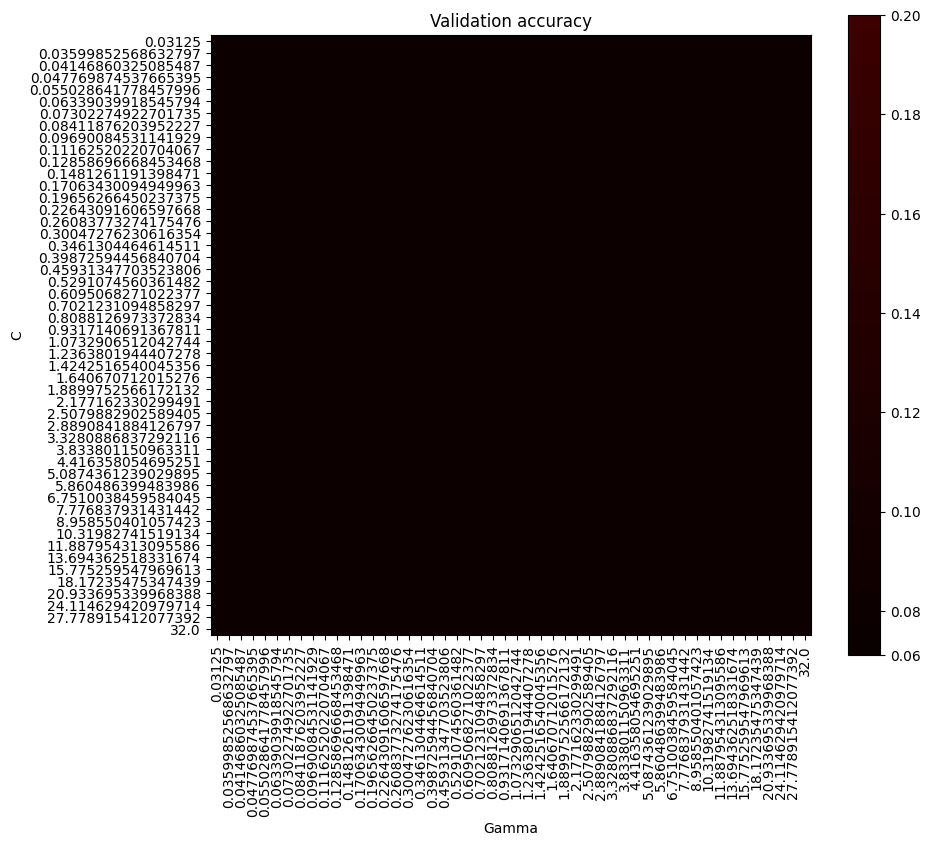

In [2103]:
plotSearchGridSVM(grid_svm)

GridSearch results indicate the optimized parameters are, 
C: 0.03125, Gamma: 0.03125, Accuracy: 0.07894960844399046
0.5522388059701493


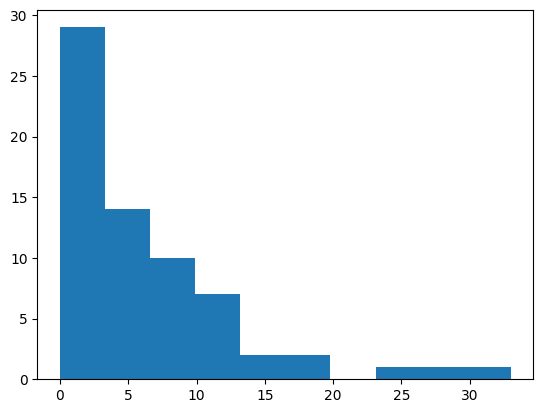

In [2104]:
scores = [x for x in grid_svm.cv_results_["mean_test_score"]]

max_index = scores.index(max(scores))
max_score = max(scores)
opt_C = grid_svm.cv_results_['param_C'][max_index]
opt_Gamma = grid_svm.cv_results_['param_gamma'][max_index]

print(f'GridSearch results indicate the optimized parameters are, \nC: {opt_C}, Gamma: {opt_Gamma}, Accuracy: {max_score}')

# OR use the attribute .best_params_
grid_svm.best_params_

results_svm = list(zip(grid_svm.predict(X_test), y_test))
pred_delta_svm = [abs(pred - truth) for pred, truth in results_svm]
plt.hist(pred_delta_svm)
print((np.array(pred_delta_svm) <= 5).sum() / len(pred_delta_svm))

#### Decision Trees

In [2105]:
dt = DecisionTreeClassifier(max_depth = None, max_leaf_nodes = None, random_state = rand_state).fit(X_train, y_train)
print(dt.score(X_train, y_train))
print(dt.score(X_test, y_test))
#path = dt.cost_complexity_pruning_path(X_train, y_train)
#ccp_alphas, impurities = path.ccp_alphas, path.impurities

1.0
0.11940298507462686


##### AdaBoost

---



In [2106]:
adaboost_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1),
                   n_estimators = 100,
                   random_state = None,
                   learning_rate = 0.5
                   ).fit(X_train, y_train)
print(adaboost_clf.score(X_test, y_test))
# results_adaboost = list(zip(adaboost_clf.predict(X_test), y_test))
# pred_delta_adaboost = [abs(pred - truth) for pred, truth in results_adaboost]
# plt.hist(pred_delta_adaboost)
# print((np.array(pred_delta_adaboost) <= 5).sum() / len(pred_delta_adaboost))

0.07462686567164178


##### Random Forest

---


In [2107]:
params = {'max_depth': np.linspace(1, 25, 25, dtype = int), 'max_leaf_nodes': np.linspace(2, 98, 25, dtype = int)}
grid = GridSearchCV(RandomForestClassifier(random_state=rand_state), param_grid = params, cv = 3, verbose = 3, n_jobs = -1).fit(X_train, y_train)

Fitting 3 folds for each of 625 candidates, totalling 1875 fits


[CV 1/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.079 total time=   0.1s
[CV 2/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.079 total time=   0.1s
[CV 2/3] END ....max_depth=1, max_leaf_nodes=10;, score=0.079 total time=   0.1s
[CV 2/3] END .....max_depth=1, max_leaf_nodes=6;, score=0.079 total time=   0.1s
[CV 3/3] END .....max_depth=1, max_leaf_nodes=6;, score=0.114 total time=   0.1s
[CV 3/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.114 total time=   0.1s
[CV 1/3] END .....max_depth=1, max_leaf_nodes=6;, score=0.079 total time=   0.1s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=10;, score=0.079 total time=   0.1s


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV 1/3] END ....max_depth=1, max_leaf_nodes=14;, score=0.079 total time=   0.1s
[CV 3/3] END ....max_depth=1, max_leaf_nodes=10;, score=0.114 total time=   0.1s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=18;, score=0.079 total time=   0.1s
[CV 2/3] END ....max_depth=1, max_leaf_nodes=14;, score=0.079 total time=   0.1s
[CV 3/3] END ....max_depth=1, max_leaf_nodes=14;, score=0.114 total time=   0.1s
[CV 2/3] END ....max_depth=1, max_leaf_nodes=18;, score=0.079 total time=   0.1s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=22;, score=0.079 total time=   0.1s
[CV 3/3] END ....max_depth=1, max_leaf_nodes=18;, score=0.114 total time=   0.1s
[CV 2/3] END ....max_depth=1, max_leaf_nodes=30;, score=0.079 total time=   0.0s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=26;, score=0.079 total time=   0.1s
[CV 2/3] END ....max_depth=1, max_leaf_nodes=22;, score=0.079 total time=   0.1s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=34;, score=0.079 total time=   0.0s
[CV 2/3] END ....max_depth=1

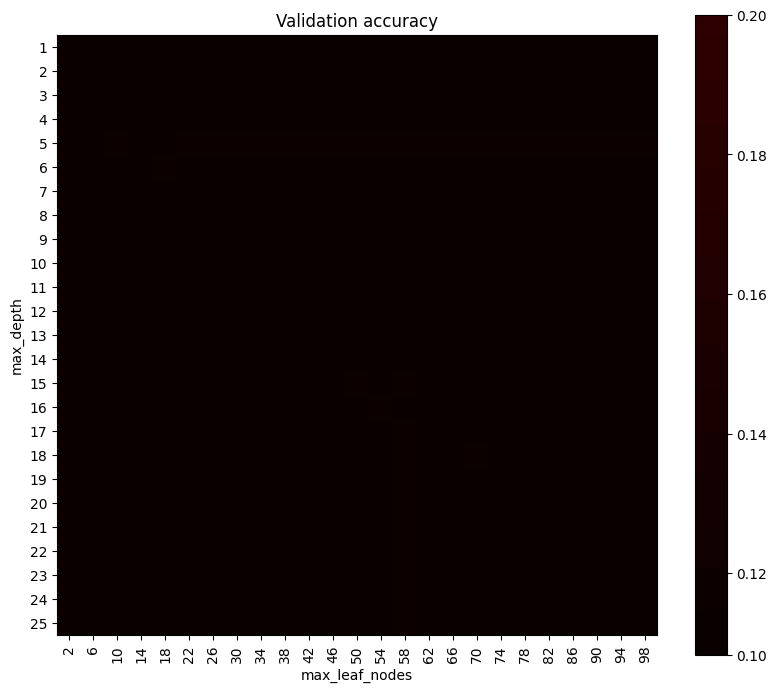

In [2108]:
plotSearchGrid(grid)

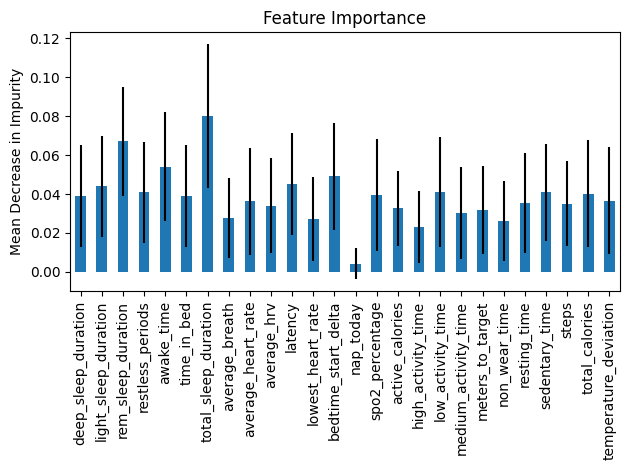

In [2109]:
feat_importance = grid.best_estimator_.feature_importances_
feat_imp_std = np.std([tree.feature_importances_ for tree in grid.best_estimator_.estimators_], axis = 0)
forest_importances = pd.Series(feat_importance, index=bio_sleep_df.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr = feat_imp_std, ax = ax)
ax.set_title("Feature Importance")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()

In [2110]:
grid.best_estimator_

RandomForestClassifier(max_depth=15, max_leaf_nodes=58, random_state=98784)

0.11940298507462686


ValueError: The number of FixedLocator locations (30), usually from a call to set_ticks, does not match the number of labels (29).

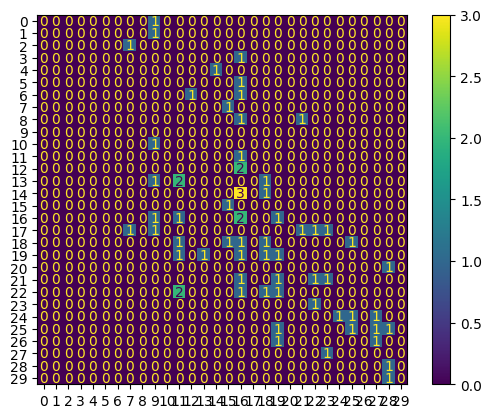

In [2111]:
print(grid.best_estimator_.score(X_test, y_test))

cm = confusion_matrix(y_test, grid.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = sorted(y_test.unique()))
disp.plot()
plt.xticks(rotation=90)
plt.show()

In [ ]:
results_bins = (grid.best_estimator_.predict(X_test))
results_bins[0]

'75.5 to 80.5'

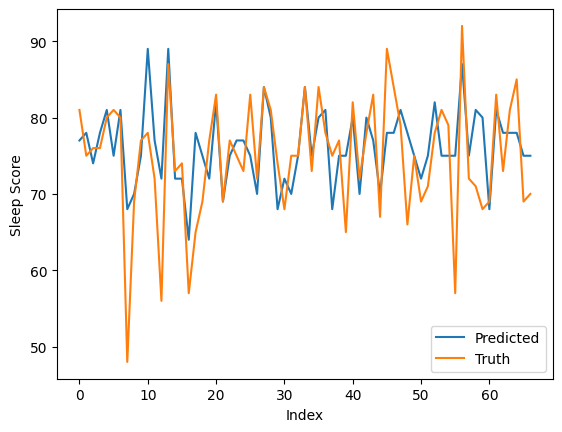

In [ ]:
results_randforrest = list(zip(grid.best_estimator_.predict(X_test), y_test))
plt.plot(results_randforrest, label = ['Predicted', 'Truth'])
plt.xlabel('Index')
plt.ylabel('Sleep Score')
plt.plot()
plt.legend()

0.6865671641791045

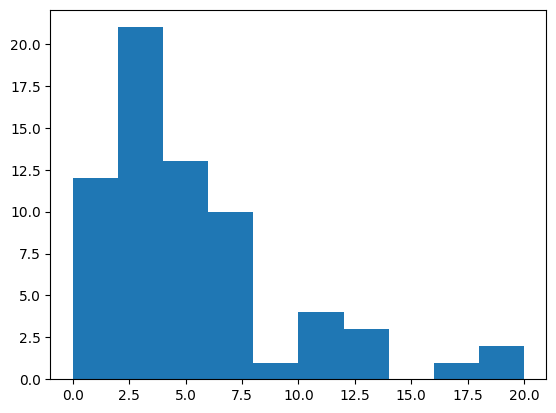

In [ ]:
pred_delta_randforrest = [abs(pred - truth) for pred, truth in results_randforrest]
plt.hist(pred_delta_randforrest)
(np.array(pred_delta_randforrest) <= 5).sum() / len(pred_delta_randforrest)